In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import *
import copy
import time
import os

import matplotlib.pyplot as plt

In [1]:
def coordinate_data(pick_up_longitude,pick_up_latitude,drop_off_longitude,drop_off_latitude):
    data = (pick_up_latitude,pick_up_longitude,drop_off_latitude,drop_off_longitude)
    return data

def time_data(pick_up_time_1,pick_up_time_2,drop_off_time_1,drop_off_time_2):
    data = (pick_up_time_1,pick_up_time_2,drop_off_time_1,drop_off_time_2)
    return data
    
def data_type_conversion(data):
    CD_data = []
    T_data = []
    for i in range(len(data)):
        d = data.iloc[i]
        CD_data.append(coordinate_data(tuple(d[2:])))
        T_data.append(time_data(tuple(d[:2])))
    return (CD_data,T_data)

def ManhattanDistance(cd_data_1,cd_data_2):
    (la_1,lo_1) = cd_data_1
    (la_2,lo_2) = cd_data_2
    la_diff = np.absolute(la_1-la_2)*111
    lo_diff = np.absolute(lo_1-lo_2)*111*np.cos((la_1+la_2)/2)
    return la_diff + lo_diff

def walking_time(cd_data_1,cd_data_2,walking_speed = 5):
    distance = ManhattanDistance(cd_data_1,cd_data_2)
    return timedelta(minutes = (distance/walking_speed)*60)

def is_feasible(cd_data_1,cd_data_2,t_data_1,t_data_2,
                driving_speed = 20,walking_speed = 5,
                distance_threshold = 0.5,time_threshold = 5):
    (p_la_1,p_lo_1,d_la_1,d_lo_1) = cd_data_1
    (p_la_2,p_lo_2,d_la_2,d_lo_2) = cd_data_2
    p_med_la = (p_la_1+p_la_2)/2
    p_med_lo = (p_lo_1+p_lo_2)/2
    dis_1 = ManhattanDistance((p_med_la,p_med_lo),(p_la_1,p_lo_1))
    if dis_1 < distance_threshold:
        dis_2 = ManhattanDistance((p_med_la,p_med_lo),(p_la_2,p_lo_2))
        if dis_2 <distance_threshold:
            time_threshold = timedelta(minutes = time_threshold)
            walk_t_1 = walking_time((p_med_la,p_med_lo),(p_la_1,p_lo_1),walking_speed)
            if walk_t_1 < time_threshold:
                walk_t_2 = walking_time((p_med_la,p_med_lo),(p_la_2,p_lo_2),walking_speed)
                if walk_t_2 < time_threshold:
                    travel_time = timedelta(minutes = ManhattanDistance((p_med_la,p_med_lo),((d_la_1+d_la_2)/2,(d_lo_1+d_lo_2)/2))/driving_speed*60)
                    (p_1,d_1) = t_data_1
                    (p_2,d_2) = t_data_2
                    if p_1 > p_2:
                        p_w_1 = walk_t_1
                        p_w_2 = (p_1 + walk_t_1) - (p_2 + walk_t_2)
                    else:
                        p_w_2 = walk_t_2
                        p_w_1 = (p_2 + walk_t_2) - (p_1 + walk_t_1)
                    
                    if (p_w_1 < time_threshold) and (p_w_2 < time_threshold):
                        depart_time = p_1 + p_w_1
                        DropOffTime = depart_time + travel_time
                        Delta_1 = timedelta(minutes = ManhattanDistance((d_la_1,d_lo_1),((d_la_1+d_la_2)/2,(d_lo_1+d_lo_2)/2))/walking_speed*60)
                        Delta_2 = timedelta(minutes = ManhattanDistance((d_la_2,d_lo_2),((d_la_1+d_la_2)/2,(d_lo_1+d_lo_2)/2))/walking_speed*60)
                        D_1 = Delta_1 + DropOffTime
                        D_2 = Delta_2 + DropOffTime  
                        if ((D_1-d_1) < time_threshold) and ((D_2-d_2) < time_threshold):
                            return True
    else:
        return False
    
    
def get_distance_matrix(CD_data,T_data,distance_threshold = 0.5,time_threshold = 5):
    AdjacencyMatrix = np.zeros((len(CD_data),len(CD_data)))
    for i in range(len(CD_data)):
        cd_data_1 = tuple(CD_data.iloc[i])
        t_data_1 = tuple(T_data.iloc[i])
        for j in range(len(CD_data)):
            cd_data_2 = tuple(CD_data.iloc[j])
            t_data_2 = tuple(T_data.iloc[j])
            if i == j:
                AdjacencyMatrix[i,j] = 0
            elif is_feasible(cd_data_1,cd_data_2,t_data_1,t_data_2,distance_threshold,time_threshold):
                AdjacencyMatrix[i,j] = 1
            else:
                AdjacencyMatrix[i,j] = 0
    return (AdjacencyMatrix,CD_data,T_data)

def matrix_to_txt(file,AdjacencyMatrix):
    file = np.savetxt(file,AdjacencyMatrix,delimiter = ' ')
    return file


def data_pre_process(table,latitude_inf,latitude_sup,longitude_inf,longitude_sup):
    remove_pay = table.drop(['payment_type'],axis = 1)
    remove_fare = remove_pay.drop(['fare_amount','tip_amount','improvement_surcharge','tolls_amount','mta_tax','extra','total_amount'],axis = 1)
    remove_ID = remove_fare.drop(['VendorID','RatecodeID'],axis = 1)
    remove_flag = remove_ID.drop(['store_and_fwd_flag'],axis = 1)

    data = remove_flag[remove_flag['passenger_count'] == 1]
    
    data = data[data.pickup_latitude < latitude_sup]
    data = data[data.pickup_latitude > latitude_inf]
    data = data[data.pickup_longitude < longitude_sup]
    data = data[data.pickup_longitude > longitude_inf]
    data = data[data.dropoff_latitude < latitude_sup]
    data = data[data.dropoff_latitude > latitude_inf]
    data = data[data.dropoff_longitude < longitude_sup]
    data = data[data.dropoff_longitude > longitude_inf]
    data = data.sort_values(by=['tpep_pickup_datetime'])
    return data
    
def limit_data(data):
    data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime,format = '%m/%d/%Y %H:%M')
    data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime,format = '%m/%d/%Y %H:%M')
    inf_time = datetime.strptime('2016-02-01 08:15:00','%Y-%m-%d %H:%M:%S')
    sup_time = datetime.strptime('2016-02-01 08:20:00','%Y-%m-%d %H:%M:%S')
    data = data[data.tpep_pickup_datetime <= sup_time]
    data = data[data.tpep_pickup_datetime >= inf_time]
    data = data.sort_values(by=['tpep_pickup_datetime'])
    return data

def get_CD_T_data(data):
    data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime,format = '%m/%d/%Y %H:%M')
    data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime,format = '%m/%d/%Y %H:%M')
    data = data.sort_values(by=['tpep_pickup_datetime'])
    CD_data = data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]
    T_data = data[['tpep_pickup_datetime','tpep_dropoff_datetime']]

    cd_data = CD_data.iloc[:100]
    t_data = T_data.iloc[:100]
    return (cd_data,t_data)

def get_time_label_data(T_data):
    max_time = max(T_data.tpep_pickup_datetime)
    min_time = min(T_data.tpep_pickup_datetime)
    min_max_diff = max_time-min_time
    min_max_diff = str(min_max_diff).split(' ')
    diff_days = int(min_max_diff[0])
    diff_hours = int(min_max_diff[-1][:2])
    diff_minutes = int(min_max_diff[-1][3:5])
    total_diff = int(np.ceil((1440*diff_days+60*diff_hours+diff_minutes)/5))
    time_label = [[0]*total_diff,[0]*total_diff]
    for i in range(total_diff):
        label = str(min_time + timedelta(minutes = 5*i))
        time_label[0][i] = label
    j = 0
    time_delta = timedelta(minutes = 5)
    while j < total_diff:
        k = 0
        while k < len(T_data):
            tl = datetime.strptime(time_label[0][j],'%Y-%m-%d %H:%M:%S')
            if (T_data.tpep_pickup_datetime.iloc[k] >= tl) and (T_data.tpep_pickup_datetime.iloc[k] < time_delta + tl):
                time_label[1][j] += 1
            if (T_data.tpep_dropoff_datetime.iloc[k] >= tl) and (T_data.tpep_dropoff_datetime.iloc[k] < time_delta + tl):
                time_label[1][j] += 1
            if T_data.tpep_pickup_datetime.iloc[k] > time_delta + tl:
                break
            k += 1
        j += 1
    
    return time_label

def model(data,test_size = 0.2):

    X,Y = data[0],data[1]
    x = [int(time.mktime(datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())) for i in X]
    x = np.array(x).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = test_size)
    model = RandomForestRegressor()
    model.fit(x_train,y_train)
    return (model,scaler)

def generate_vehicle_for_one_point(trained_model,scaler,in_time):
    in_time = scaler.transform(time.mktime(datetime.strptime(in_time,'%Y-%m-%d %H:%M:%S').timetuple()))
    num_vehicle = trained_model.predict(in_time)
    la_num = int(np.floor(np.sqrt(num_vehicle)))
    lo_num = int(np.floor(np.sqrt(num_vehicle)))
    la_uniform_distribution = np.random.uniform(low = latitude_inf,high = latitude_sup,size = la_num)
    lo_uniform_distribution = np.random.uniform(low = longitude_inf,high = longitude_sup,size = lo_num)
    la_mesh,lo_mesh = np.meshgrid(la_uniform_distribution,lo_uniform_distribution)
    la_mesh = np.matrix(la_mesh)
    lo_mesh = np.matrix(lo_mesh)
    
    return (la_mesh,lo_mesh)

def generate_vehicle(model,time_label):
    # here, time_label is the first list of time_label in data_pre_process
    Vehicle_Location = dict()
    for i in range(len(time_label)):
        Vehicle_Location[time_label[i]] = generate_vehicle_for_one_point(model,time_label[i])
    return Vehicle_Location

def is_vehicle_passenger_feasible(vehicle_location,passenger_location,vehicle_speed = 20,time_threshold = 5):
    # pasenger_pickup_time is a string 
    distance = ManhattanDistance(vehicle_location,passenger_location)
    waiting_time = distance/vehicle_speed *60
    if waiting_time > time_threshold:
        return False
    else:
        return True

def get_vehicle_passenger_matrix_for_one_point(Vehicle_Location,Passenger_Location,model,vehicle_speed = 20,time_threshold = 5):
    (LA_Location,LO_Location) = Vehicle_Location
    AdjacencyMatrix = np.zeros((len(LA_Location),len(Passenger_Location)))
    for i in range(len(LA_Location)):
        for k in range(len(LO_Location)):
            vehicle_location = (LA_Location[i,k],LO_Location[i,k])
            for j in range(len(Passenger_Locaiton)):
                passenger_location = tuple(Passenger_Location.iloc[j])
                if is_vehicle_passenger_feasible(vehicle_location,passenger_location):
                    AdjacencyMatrix[i][j] = 1
                else:
                    AdjacencyMatrix[i][j] = 0
                
    return AdjacencyMatrix

def get_time_label_data(T_data):
    inf_time = datetime.strptime('2016-02-01 07:00:00','%Y-%m-%d %H:%M:%S')
    sup_time = datetime.strptime('2016-02-01 08:17:00','%Y-%m-%d %H:%M:%S')
    T_data = T_data[T_data.tpep_pickup_datetime <= sup_time]
    T_data = T_data[T_data.tpep_pickup_datetime >= inf_time]
    min_time = datetime.strptime('2016-02-01 08:15:00','%Y-%m-%d %H:%M:%S')
    time_label = 0
    time_delta = timedelta(minutes = 5)
    k = 0
    while k < len(T_data):
        if (T_data.tpep_pickup_datetime.iloc[k] >= min_time) and (T_data.tpep_pickup_datetime.iloc[k] < time_delta + min_time):
            time_label += 1
        if (T_data.tpep_dropoff_datetime.iloc[k] >= min_time) and (T_data.tpep_dropoff_datetime.iloc[k] < time_delta + min_time):
            time_label += 1
        if T_data.tpep_pickup_datetime.iloc[k] > time_delta + min_time:
            break
        k += 1
    
    return time_label

def generate_vehicle_for_one_point(num_vehicle,la_lo_ratio):
    la_num = int(np.floor(np.sqrt(num_vehicle*la_lo_ratio)))
    lo_num = int(np.floor(np.sqrt(num_vehicle/la_lo_ratio)))
    la_uniform_distribution = np.random.uniform(low = latitude_inf,high = latitude_sup,size = la_num)
    lo_uniform_distribution = np.random.uniform(low = longitude_inf,high = longitude_sup,size = lo_num)
    
    return (la_uniform_distribution,lo_uniform_distribution)
# (la_mesh,lo_mesh)

def generate_vehicle(num_vehicle):
    # here, time_label is the first list of time_label in data_pre_process
    Vehicle_Location = dict()
    for i in range(len(num_vehicle)):
        Vehicle_Location[num_vehicle[i]] = generate_vehicle_for_one_point(model,num_vehicle[i])
    return Vehicle_Location

def is_vehicle_passenger_feasible(vehicle_location,passenger_location,vehicle_speed = 20,time_threshold = 5):
    # pasenger_pickup_time is a string 
    distance = ManhattanDistance(vehicle_location,passenger_location)
    waiting_time = distance/vehicle_speed *60
    if waiting_time > time_threshold:
        return False
    else:
        return True

def generate_vehicle_location_matrix(vehicle_location):
    (latitude,longitude) = vehicle_location
    location_matrix = []
    for i in range(len(latitude)):
        for j in range(len(longitude)):
            location_matrix.append([latitude[i],longitude[i]])
    return location_matrix

def vehicle_passenger_distance(vehicle_location,passenger_location):
    location_matrix = generate_vehicle_location_matrix(vehicle_location,passenger_location)
    distance_matrix = []
    for i in range(len(passenger_location)):
        distance_matrix.append([])
        for j in range(len(location_matrix)):
            distance_matrix[i].append([])
            for k in range(len(location_matrix[i])):
                distance = ManhattanDistance(location_matrix[j][k],passenger_location[i])
                distance_matrix.append(distance)
    return distance_matrix

def adjacent_vehicles_for_passenger(passenger_location,vehicle_location):
    distance_matrix = vehicle_passenger_distance(vehicle_location,passenger_location)
    vehicle_matrix = generate_vehicle_for_one_point(vehicle_location)
    adjacent_vehicles = []
    adjacent_vehicles_index = []
    for i in range(len(passenger_location)):
        ind_sorted = np.argsort(np.array(distance_matrix[i]))
        adjacent_vehicles.append(list(np.sort_values(distance_matrix[i])))
        adjacent_vehicles_index.append(ind_sorted)
    return (adjacent_vehicles,adjacent_vehicles_index)
    
def get_vehicle_passenger_matrix_for_one_point(Vehicle_Location,Passenger_Location,vehicle_speed = 20,time_threshold = 5):
    (LA_Location,LO_Location) = Vehicle_Location
    print(len(LA_Location),len(LO_Location))
    num_vehicle = len(LO_Location)
    AdjacencyMatrix = np.zeros((len(LA_Location)*len(LO_Location),len(Passenger_Location)),dtype = np.int8)
    for i in range(len(LA_Location)): # len(LA_Location)
        for k in range(len(LO_Location)): # len(LO_Location)
            vehicle_location = (LA_Location[i],LO_Location[k])
            for j in range(len(Passenger_Location)):
                passenger_location = tuple(Passenger_Location.iloc[j])[:2]
                if is_vehicle_passenger_feasible(vehicle_location,passenger_location):
                    AdjacencyMatrix[k+num_vehicle*i][j] = 1
                else:
                    AdjacencyMatrix[k+num_vehicle*i][j] = 0
                
    return AdjacencyMatrix

def matrix_to_txt(file,VPAdjacencyMatrix):
    File = np.savetxt(file,VPAdjacencyMatrix,fmt = '%1d')
    return File

def calculate_vehicle_numbers(latitude_inf,latitude_sup,longitude_inf,longitude_sup):
    area = (latitude_sup - latitude_inf)*111*(longitude_sup - longitude_inf)*111
    density = 16.8919/8
    number = np.ceil(area*density)
    return number
    

In [3]:
path = '.\yellow_tripdata_2016-02.txt'
table = pd.read_table(path)

In [4]:
# t1 = datetime.now()

latitude_inf = 40.7406
# 40.7406
latitude_sup = 40.7612
# 40.7612
longitude_inf = -73.9993
# -73.9993
longitude_sup = -73.9781
# -73.9781
delta = 0.01

max_latitude = 40.8320
min_latitude = 40.6993
max_longitude = -73.9262
min_longitude = -74.0213

latitude_inf = min_latitude + 0.03
latitude_sup = max_latitude - 0.03
longitude_inf = min_longitude + 0.03
longitude_sup = max_longitude - 0.03

la_interval = 0.001
lo_interval = 0.001

num_edges = []

data = data_pre_process(table,latitude_inf,latitude_sup,longitude_inf,longitude_sup)
limitdata = limit_data(data)
(CD_data,T_data) = get_CD_T_data(data)
(limit_CD_data,limit_T_data) = get_CD_T_data(limitdata)
la_lo_ratio = (latitude_sup - latitude_inf)/(longitude_sup - longitude_inf)
num_vehicle = calculate_vehicle_numbers(latitude_inf,latitude_sup,longitude_inf,longitude_sup)

vehicle_location = generate_vehicle_for_one_point(num_vehicle,la_lo_ratio)
VPAdjacencyMatrix = get_vehicle_passenger_matrix_for_one_point(vehicle_location,limit_CD_data)
VPfile = 'VPfile.txt'
matrix_to_txt(VPfile,VPAdjacencyMatrix)
#     t2 = datetime.now()
#     print(t2-t1)
num_edges.append(np.sum(VPAdjacencyMatrix))
#     latitude_inf -= la_interval
#     latitude_sup += la_interval
#     longitude_inf -= lo_interval
#     longitude_sup += lo_interval

11 5


In [9]:
vehicle_location

(array([40.77782957, 40.78200916, 40.74760452, 40.80121442, 40.77254007,
        40.76618617, 40.79024448, 40.74634552, 40.78366754, 40.72971037,
        40.79033506]),
 array([-73.96345715, -73.95653504, -73.96254018, -73.98188057,
        -73.97343091]))

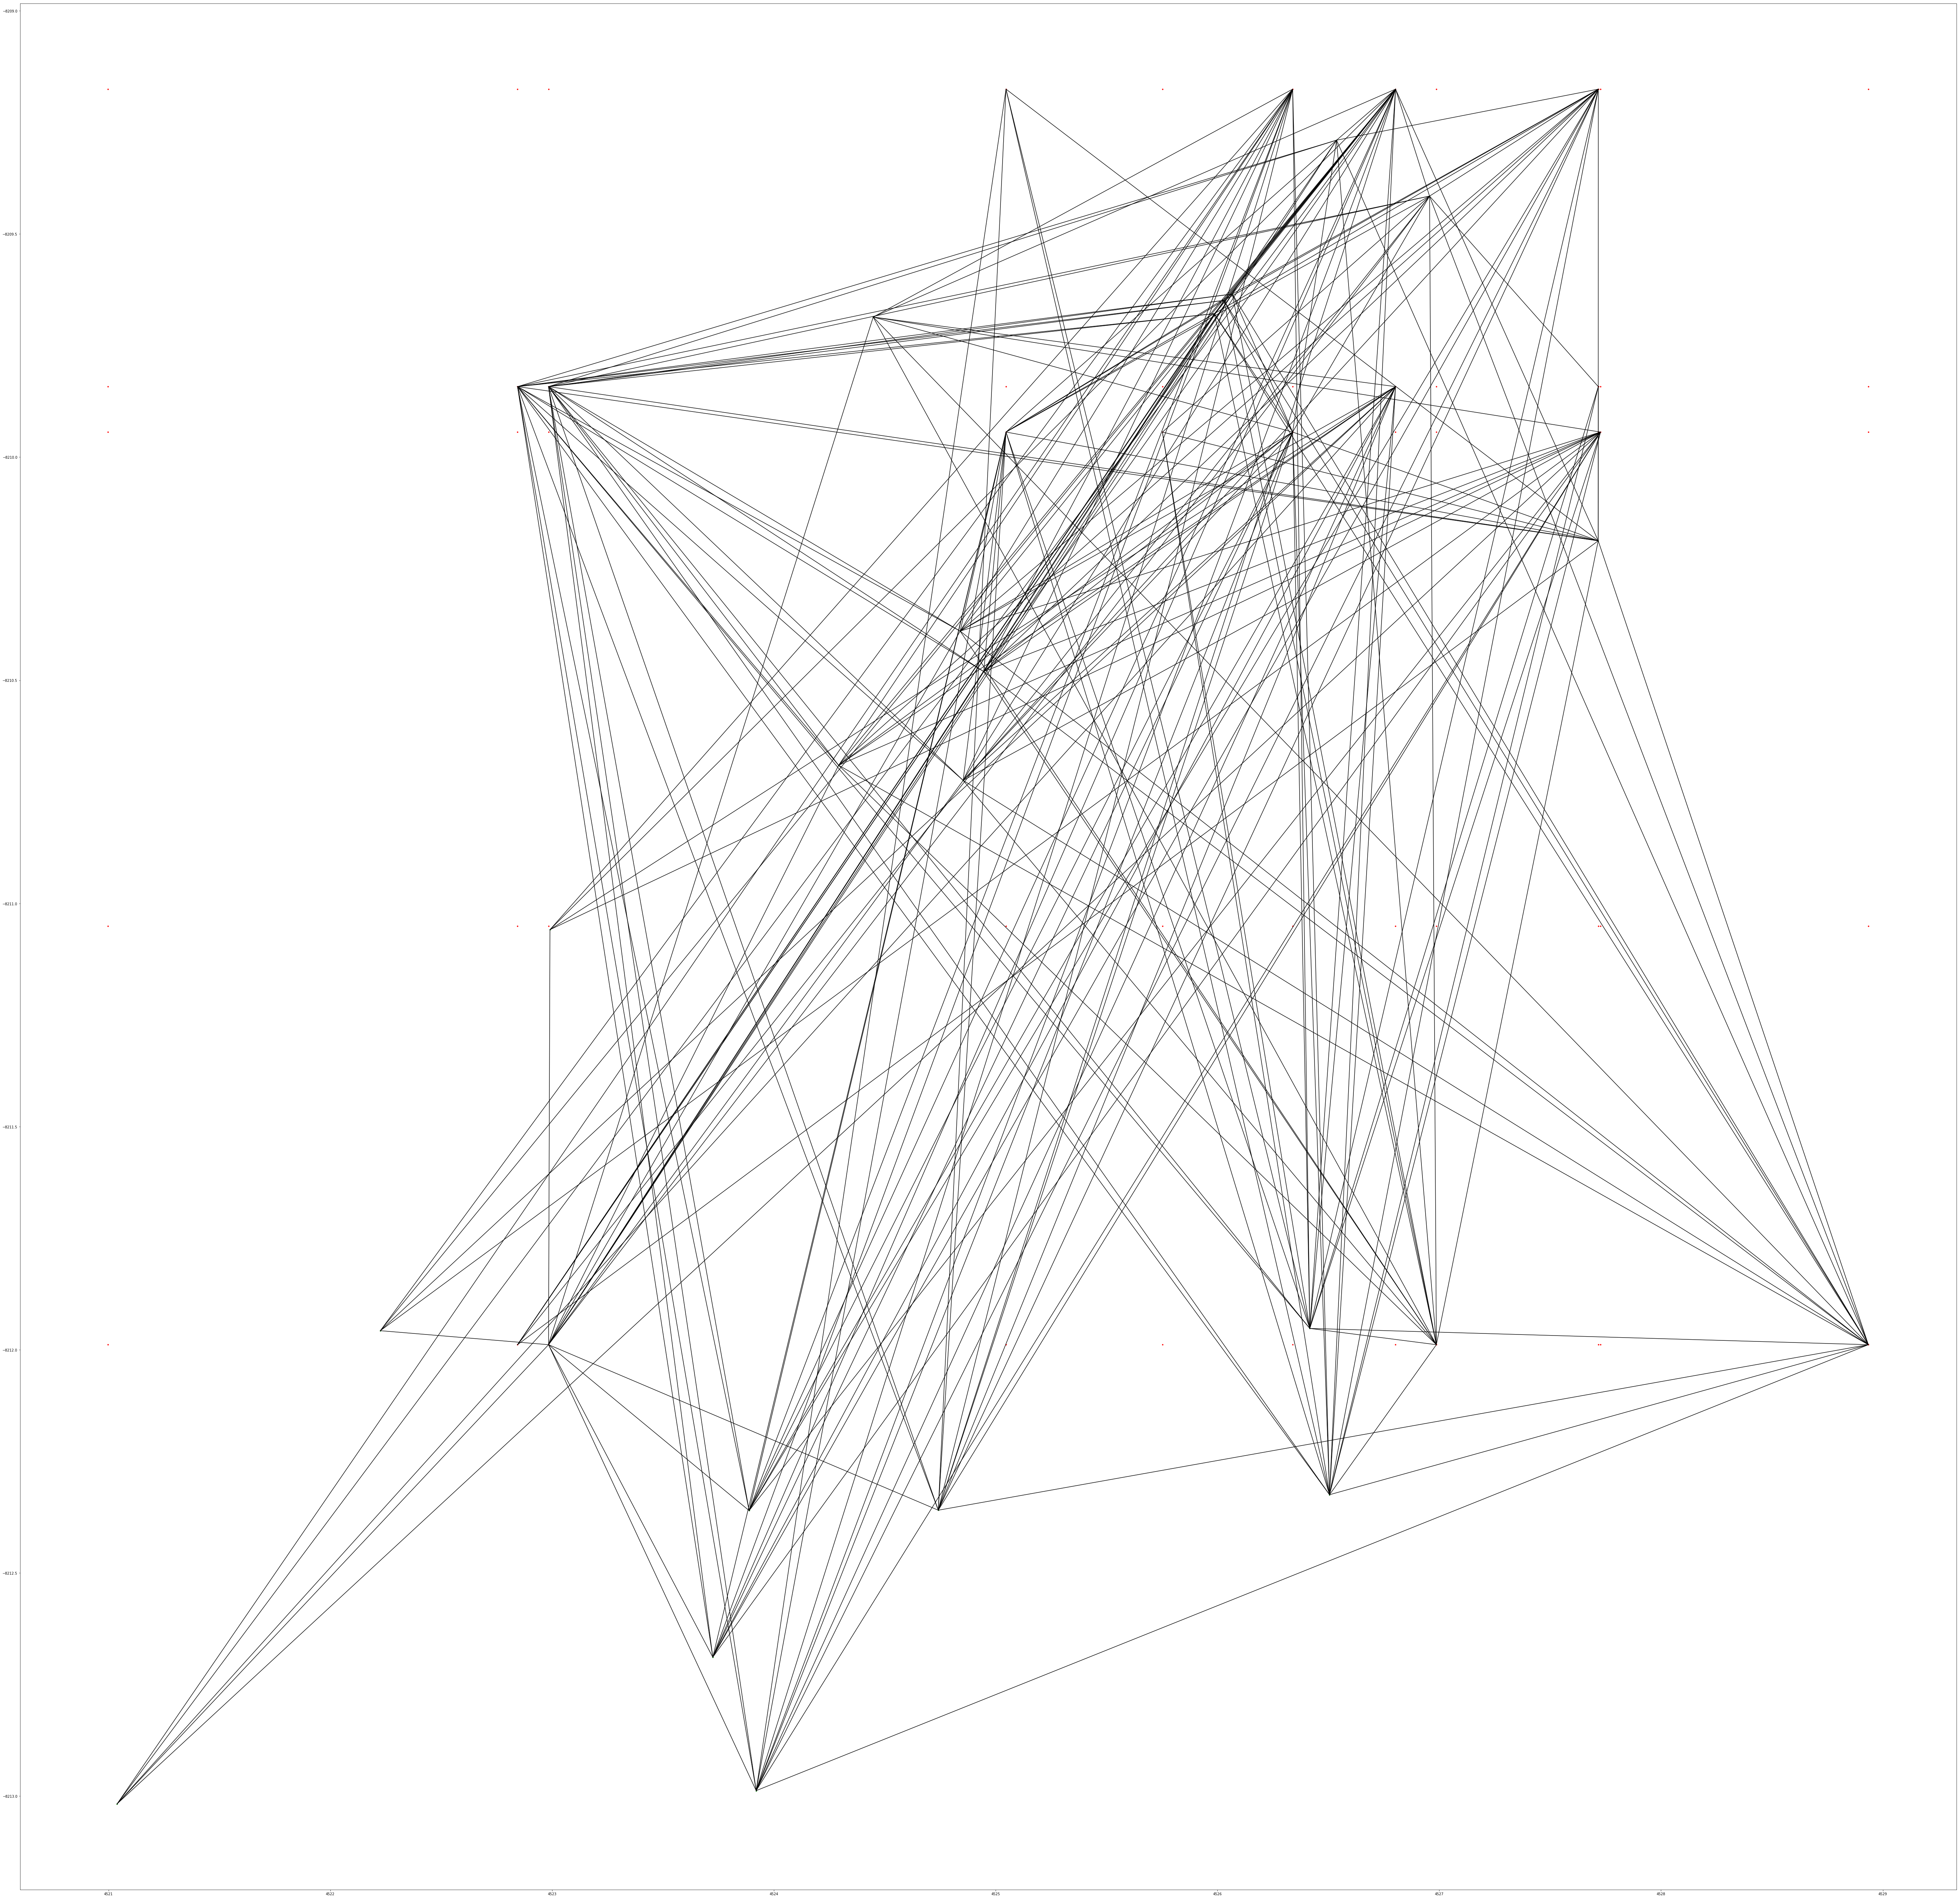

In [5]:
def plot_place_with_lo_la(latitude,longitude):
    
    x = []
    for i in range(len(longitude)):
        x = np.concatenate((x,latitude*111))
    y = []
    for j in range(len(latitude)):
        y = np.concatenate((y,longitude*111))
    
    plt.figure(figsize = (50,50))
    plt.scatter(x,y)
    plt.show()


num_passengers = 20

passenger_la = np.array(limit_CD_data['pickup_latitude'][:num_passengers])
passenger_lo = np.array(limit_CD_data['pickup_longitude'][:num_passengers])

(vehicle_la,vehicle_lo) = vehicle_location

LA = np.concatenate((passenger_la,vehicle_la))
LO = np.concatenate((passenger_lo,vehicle_lo))

# x1 = []
# for i in range(len(passenger_lo)):
#     x1 = np.concatenate((x1,passenger_la*111))
# y1 = []
# for i in range(len(passenger_la)):
#     y1 = np.concatenate((y1,passenger_lo*111))

x2 = []
for i in range(len(vehicle_lo)):
    x2 = np.concatenate((x2,vehicle_la*111))
y2 = []
for i in range(len(vehicle_la)):
    y2 = np.concatenate((y2,vehicle_lo*111))

plt.figure(figsize = (100,100))
# plt.scatter(passenger_la*111,passenger_lo*111,c = 'g')
# plt.scatter(x2,y2,c = 'r')

plt.plot(x2,y2,'r.')
plt.plot(passenger_la*111,passenger_lo*111,'g.')

for i in range(len(VPAdjacencyMatrix)):
    for j in range(num_passengers):
        if VPAdjacencyMatrix[i][j] == 1:
            plt.plot([passenger_la[j]*111,x2[i]],[passenger_lo[j]*111,y2[i]],'k-')

In [72]:
passenger_la[1]

40.77932739

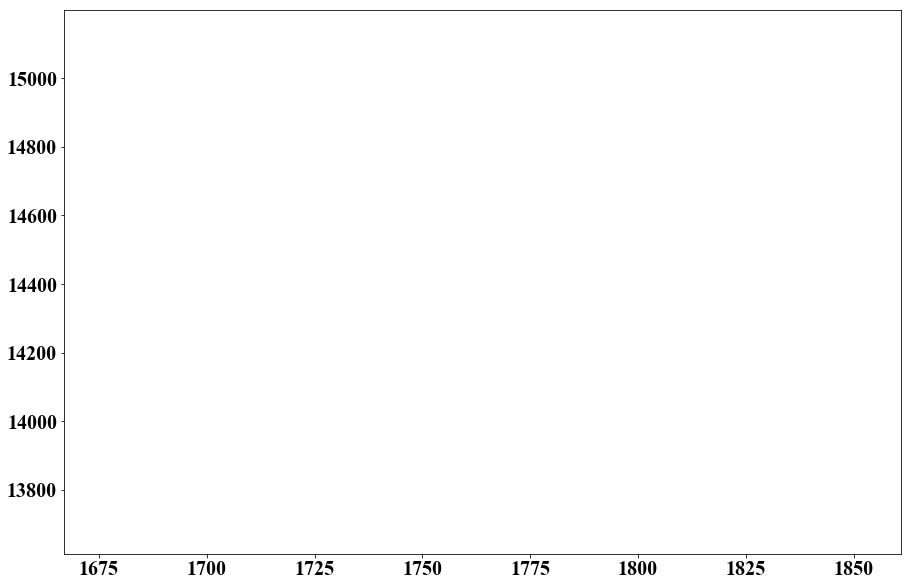

<Figure size 432x288 with 0 Axes>

In [22]:
figsize = (15,10)
figure_1,ax_1 = plt.subplots(figsize = figsize)
font1 = {'family' : 'Times New Roman',  
    'weight' : 'normal',  
    'size'   : 20,  
    }  

plt.tick_params(labelsize=20)  
labels = ax_1.get_xticklabels() + ax_1.get_yticklabels()  
[label.set_fontname('Times New Roman') for label in labels]  
#plt.yticks((np.arange(7)+1)*0.05,('5%','10%','15%','20%','25%','30%','35%'))
font2 = {'family' : 'Times New Roman',  
    'weight' : 'normal',  
    'size'   : 30,  
    } 
Num_vehicles = [(3+i*2)*(14+i*2) for i in range(len(num_edges))]
plt.plot(np.square(Num_vehicles),num_edges)
plt.show()
plt.savefig('edges.png',dpi = 100)

In [ ]:
for i in range(1):
    data = data_pre_process(table,latitude_inf,latitude_sup,longitude_inf,longitude_sup)
    limitdata = limit_data(data)
    (CD_data,T_data) = get_CD_T_data(data)
    (limit_CD_data,limit_T_data) = get_CD_T_data(limitdata)
    la_lo_ratio = (latitude_sup - latitude_inf)/(longitude_sup - longitude_inf)
    num_vehicle = (5*(latitude_sup - latitude_inf)/0.002)*(5*(longitude_sup - longitude_inf)/0.01)
    vehicle_location = generate_vehicle_for_one_point(num_vehicle,la_lo_ratio)
    VPAdjacencyMatrix = get_vehicle_passenger_matrix_for_one_point(vehicle_location,limit_CD_data)
    VPfile = 'VPfile.txt'
    matrix_to_txt(VPfile,VPAdjacencyMatrix)
#     t2 = datetime.now()
#     print(t2-t1)
    num_edges.append(np.sum(VPAdjacencyMatrix))
    latitude_inf -= la_interval
    latitude_sup += la_interval
    longitude_inf -= lo_interval
    longitude_sup += lo_interval

In [15]:
num = len(limit_T_data)
cd_data = limit_CD_data[:num]
cd_data.index = range(num)
t_data = limit_T_data[:num]
t_data.index = range(num)


In [16]:
t1 = datetime.now()

(AdjacencyMatrix,cd_data,t_data) = get_distance_matrix(cd_data,t_data)

t2 = datetime.now()
print(t2-t1)

0:00:04.398862


In [17]:
matrix_to_txt('file.txt',AdjacencyMatrix)

In [27]:
cd

50